1. Add feature selection method for linear models (test fitting on full data as opposed to fold splits)
2. figure out submission path, need to save all models and load them back in
3. add lags
4. add min-max scaler
3. switch to hgbg
4. add correlation feature selection
7. feature engineering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c mitsui-commodity-prediction-challenge
!unzip /content/mitsui-commodity-prediction-challenge.zip
!rm /content/mitsui-commodity-prediction-challenge.zip

Mounted at /content/drive
  0% 0.00/10.4M [00:00<?, ?B/s]
100% 10.4M/10.4M [00:00<00:00, 1.07GB/s]
Archive:  /content/mitsui-commodity-prediction-challenge.zip
  inflating: kaggle_evaluation/__init__.py  
  inflating: kaggle_evaluation/core/__init__.py  
  inflating: kaggle_evaluation/core/base_gateway.py  
  inflating: kaggle_evaluation/core/generated/__init__.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py  
  inflating: kaggle_evaluation/core/kaggle_evaluation.proto  
  inflating: kaggle_evaluation/core/relay.py  
  inflating: kaggle_evaluation/core/templates.py  
  inflating: kaggle_evaluation/mitsui_gateway.py  
  inflating: kaggle_evaluation/mitsui_inference_server.py  
  inflating: lagged_test_labels/test_labels_lag_1.csv  
  inflating: lagged_test_labels/test_labels_lag_2.csv  
  inflating: lagged_test_labels/test_labels_lag_3.csv  
  inflating: lagged_test_labels/test_labe

In [2]:
%%capture
!pip install optuna
!mkdir oof
!mkdir models

## Import Packages

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from sklearn.feature_selection import f_classif
import warnings
import pickle
from pathlib import Path
import gc
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

## Load Data

In [19]:
class CFG:
  OOF_DATA_PATH = Path('./oof')
  MODEL_DATA_PATH = Path('./models')
  N_SPLIT = 5
  K = 5 #Lag + 4-Feature

In [20]:
train = pd.read_csv('/content/train.csv', index_col = 0)
train = train.iloc[:1827]
test = pd.read_csv('/content/test.csv', index_col = 0)
# sub = pd.read_csv('/content/sample_submission.csv')
train_labels = pd.read_csv('/content/train_labels.csv', index_col = 0)
test_labels = train_labels.iloc[1827:]
train_labels = train_labels.iloc[:1827]
target_pairs = pd.read_csv('/content/target_pairs.csv')

In [21]:
## Lagged Data
test_lag1 = pd.read_csv('/content/lagged_test_labels/test_labels_lag_1.csv', index_col = 0 ).drop('label_date_id', axis = 1)
test_lag2 = pd.read_csv('/content/lagged_test_labels/test_labels_lag_2.csv', index_col = 0 ).drop('label_date_id', axis = 1)
test_lag3 = pd.read_csv('/content/lagged_test_labels/test_labels_lag_3.csv', index_col = 0 ).drop('label_date_id', axis = 1)
test_lag4 = pd.read_csv('/content/lagged_test_labels/test_labels_lag_4.csv', index_col = 0 ).drop('label_date_id', axis = 1)

test_lag = pd.concat([test_lag1, test_lag2, test_lag3, test_lag4], axis = 1)

In [22]:
rename_map = {row['target']: f"{row['target']}_lag{row['lag']}"
              for _, row in target_pairs.iterrows()}
test_lag = test_lag.rename(columns=rename_map)
test = test.merge(test_lag, how="left", left_index=True, right_index=True)

## Preprocessing

In [23]:
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    """
    Calculates the rank correlation between predictions and target values,
    and returns its Sharpe ratio (mean / standard deviation).

    :param merged_df: DataFrame containing prediction columns (starting with 'prediction_')
                      and target columns (starting with 'target_')
    :return: Sharpe ratio of the rank correlation
    :raises ZeroDivisionError: If the standard deviation is zero
    """
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]

    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]

    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates the rank correlation between predictions and target values,
    and returns its Sharpe ratio (mean / standard deviation).
    """
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    assert all(solution.columns == submission.columns)

    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})

    # Not all securities trade on all dates, but solution files cannot contain nulls.
    # The filler value allows us to handle trading halts, holidays, & delistings.
    solution = solution.replace(-9999, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [24]:
# target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()
len(numeric_cols), len(categorical_cols)

(982, 0)

In [25]:
train.shape, test.shape
# , sub.shape

((1827, 557), (134, 982))

## Feature Engineering

In [26]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add time-based forecasting features using only `date_id`.
    Does not rely on target values.
    Assumes df has a 'date_id' column.
    """
    df = df.copy()

    # --- Calendar-like features ---
    df['dayofweek'] = df['date_id'] % 7
    df['month'] = (df['date_id'] // 30) % 12
    df['quarter'] = df['month'] // 3
    df['day_of_month'] = df['date_id'] % 30

    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['day_of_month'] == 0).astype(int)
    df['is_month_end'] = (df['day_of_month'] == 29).astype(int)

    # --- Cyclical encodings ---
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    return df


In [27]:
# Add time features (no target dependency)
time_features = add_time_features(train.reset_index()[['date_id']]).set_index('date_id')

# Merge into feature set
full_features_df = pd.concat([train, time_features], axis=1)
train = full_features_df.copy(deep=True)

time_features = add_time_features(test.reset_index()[['date_id']]).set_index('date_id')

# Merge into feature set
full_features_df = pd.concat([test, time_features], axis=1)
test = full_features_df.copy(deep=True)

In [28]:
train = train.fillna(-9999)
test = test.fillna(-9999)

## EDA

### Missing Values Check

In [ ]:
# Target
train_labels.isna().sum().sort_values()

,0
target_318,0
target_212,0
target_39,81
target_3,81
target_43,81
...,...
target_270,327
target_276,327
target_285,327
target_269,327


In [ ]:
train_labels.head()

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
date_id,,,,,,,,,,,,,,,,,,,,,
0,0.005948,-0.002851,-0.004675,-0.000639,NaN,NaN,-0.006729,0.006066,NaN,0.003446,...,NaN,0.021239,-0.005595,NaN,-0.004628,0.033793,NaN,0.038234,NaN,0.027310
1,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,0.021284,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,0.001048,0.023836,-0.008934,-0.022060,NaN,NaN,0.037449,0.007658,NaN,-0.026844,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706
3,0.001700,-0.024618,0.011943,0.004778,NaN,NaN,-0.012519,-0.016896,NaN,0.014843,...,NaN,0.036880,-0.015189,NaN,0.008118,0.001079,NaN,-0.015102,NaN,-0.033010
4,-0.003272,0.005234,0.006856,0.013312,0.023953,0.010681,-0.011649,0.002019,0.003897,-0.008985,...,NaN,0.004937,NaN,-0.006673,-0.016105,-0.004885,NaN,NaN,0.009514,NaN


In [ ]:
train.isna().sum().sort_values().tail(25)

,0
JPX_Platinum_Mini_Futures_Open,110
JPX_Gold_Standard_Futures_Open,110
JPX_Gold_Rolling-Spot_Futures_Open,110
JPX_Gold_Mini_Futures_Volume,110
JPX_Gold_Mini_Futures_Open,110
JPX_RSS3_Rubber_Futures_settlement_price,110
JPX_Platinum_Mini_Futures_settlement_price,110
JPX_Gold_Rolling-Spot_Futures_settlement_price,110
JPX_Gold_Mini_Futures_settlement_price,110
JPX_Gold_Mini_Futures_open_interest,110


### Plots

#### Numeric

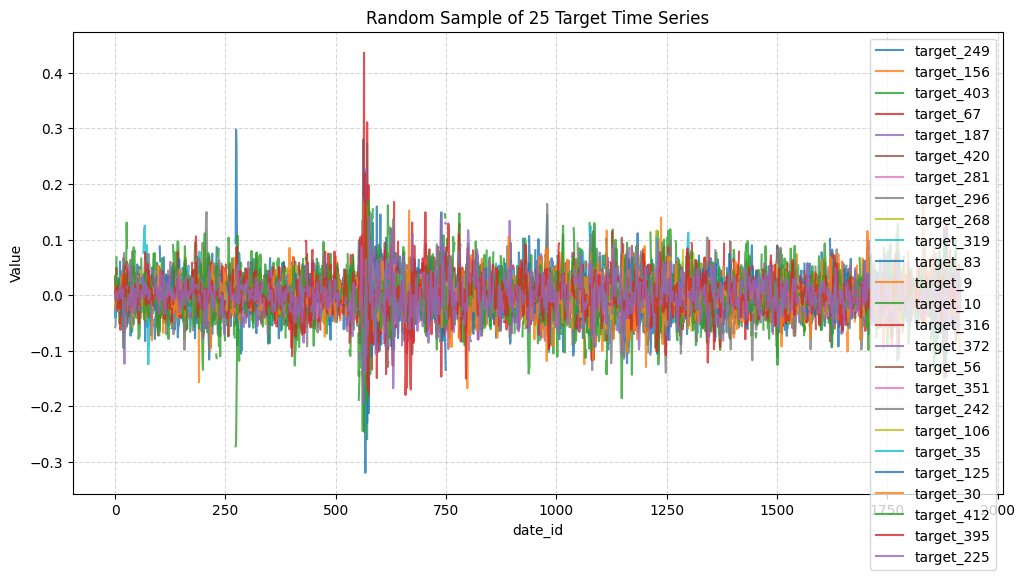

In [ ]:
N = 25  # number of random columns to plot
sampled_cols = np.random.choice(train_labels.columns, size=N, replace=False)

# Plot time series
plt.figure(figsize=(12, 6))
for col in sampled_cols:
    plt.plot(train_labels.index, train_labels[col], label=col, alpha=0.8)

plt.title(f"Random Sample of {N} Target Time Series")
plt.xlabel("date_id")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

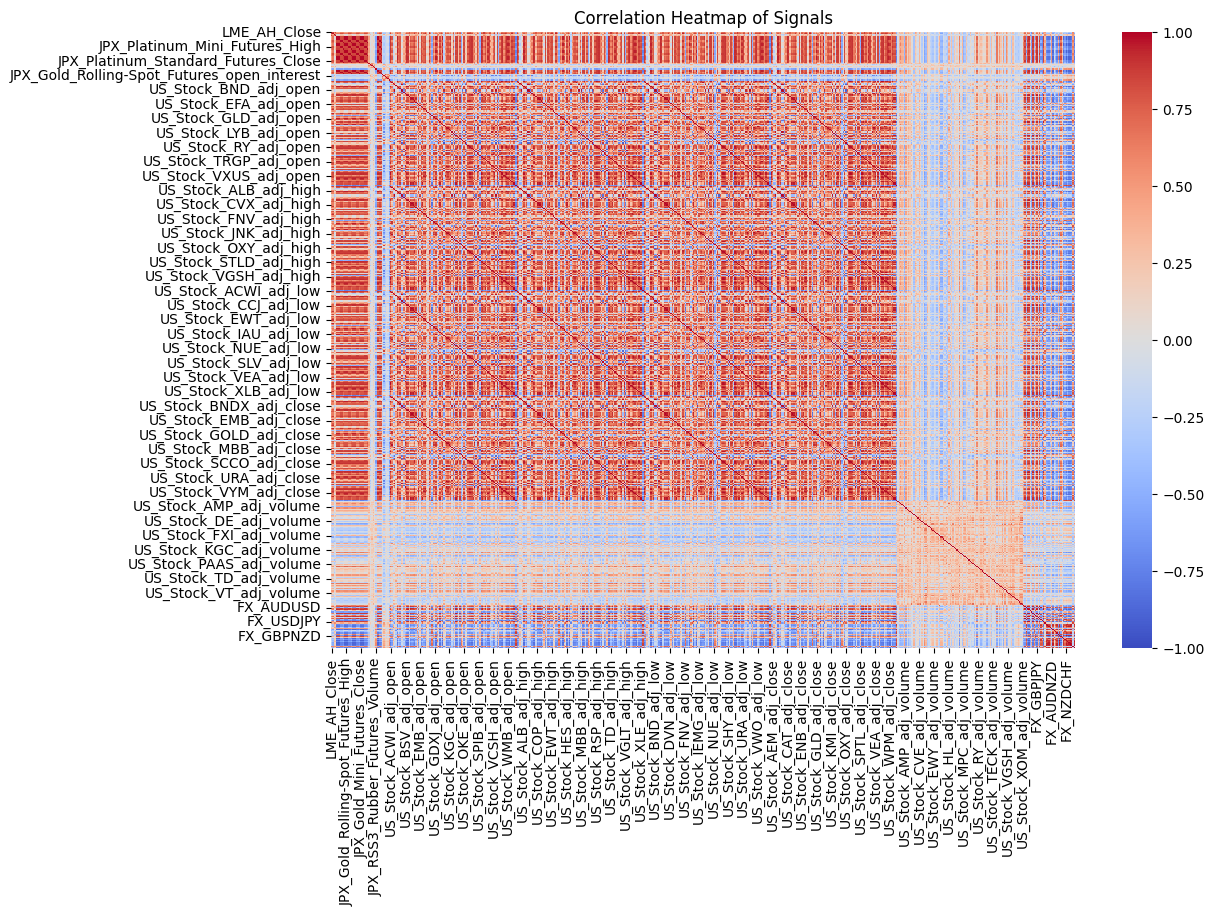

In [ ]:
corr = train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin = -1, vmax = 1)
plt.title("Correlation Heatmap of Signals")
plt.show()

In [ ]:
for col in train.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(train.index, train[col], label=col)
    plt.title(f"Time Series Plot - {col}")
    plt.xlabel("date_id")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Unique

In [ ]:
def generate_log_returns(data, lag):
    log_returns = pd.Series(np.nan, index=data.index)

    # Compute log returns based on the rules
    for t in range(len(data)):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            try:
                log_returns.iloc[t] = np.log(data.iloc[t + lag + 1] / data.iloc[t + 1])
            except Exception:
                log_returns.iloc[t] = np.nan
    return log_returns


def generate_targets(column_a: pd.Series, column_b: pd.Series, lag: int) -> pd.Series:
    a_returns = generate_log_returns(column_a, lag)
    b_returns = generate_log_returns(column_b, lag)
    return a_returns - b_returns

## Linear Regression Models

In [ ]:
# class LagFeatureSelector(BaseEstimator, TransformerMixin):
#     """Custom transformer that ensures lag feature is always included
#        along with SelectKBest(k-1) other features."""
#     def __init__(self, lag_feature: str, k: int = 5):
#         self.lag_feature = lag_feature
#         self.k = k
#         self.selected_features_ = None
#         self.selector_ = None

#     def fit(self, X, y):
#         # Separate lag feature from others
#         other_features = X.drop(columns=[self.lag_feature])
#         lag_col = X[[self.lag_feature]]

#         # Run SelectKBest on other features
#         self.selector_ = SelectKBest(score_func=f_regression, k=self.k - 1)
#         self.selector_.fit(other_features, y)

#         selected_other = other_features.columns[self.selector_.get_support()]
#         self.selected_features_ = [self.lag_feature] + list(selected_other)
#         return self

#     def transform(self, X):
#         return X[self.selected_features_]

#     def get_feature_names_out(self, input_features=None):
#         return self.selected_features_

class LagFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, lag_feature: str, k: int = 5, feature_names=None):
        self.lag_feature = lag_feature
        self.k = k
        self.selected_features_ = None
        self.selector_ = None
        self.feature_names_in_ = feature_names  # allow passing manually

    def fit(self, X, y):
        # If ndarray, convert using stored names
        if isinstance(X, np.ndarray):
            if self.feature_names_in_ is None:
                raise ValueError("LagFeatureSelector requires feature names, but none were provided.")
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        else:
            self.feature_names_in_ = list(X.columns)

        other_features = X.drop(columns=[self.lag_feature])
        self.selector_ = SelectKBest(score_func=f_regression, k=self.k - 1)
        self.selector_.fit(other_features, y)

        selected_other = other_features.columns[self.selector_.get_support()]
        self.selected_features_ = [self.lag_feature] + list(selected_other)
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        return X[self.selected_features_]

    def get_feature_names_out(self, input_features=None):
        return self.selected_features_



In [ ]:
def get_target_lag_features(train_labels: pd.DataFrame, target_col: str, lag: int) -> pd.Series:
    """
    Create a lag feature for a specific target column.

    Args:
        train_labels: DataFrame of targets
        target_col: target column name (e.g., 'target_0')
        lag: how many steps to lag

    Returns:
        pd.Series with lagged values (named f"{target_col}_lag{lag}")
    """
    return train_labels[target_col].shift(lag).rename(f"{target_col}_lag{lag}")


def linear_regression_model_cv_training(
    train_df: pd.DataFrame,
    features: list,
    train_labels: pd.DataFrame,
    target_pairs: pd.DataFrame,
    K = CFG.K
):
    """
    Train LinearRegression models with CV for multiple target columns,
    using SelectKBest and target-specific lag features from `target_pairs`.

    Args:
        train_df: DataFrame with features + cv_flag
        features: list of base feature column names
        train_labels: DataFrame of targets
        target_pairs: DataFrame with columns [target, lag] specifying
                      which lag to use for each target.

    Returns:
        oof_df: DataFrame of out-of-fold predictions
        models: dict of {target_col: list of models per fold}
    """

    # OOF predictions dataframe
    oof_df = pd.DataFrame(
        np.nan, index=train_labels.index, columns=train_labels.columns
    )
    models = {}

    for _, row in target_pairs.iterrows():
        target_col = row["target"]
        lag = int(row["lag"])

        print("=" * 60)
        print(f"Training for {target_col} with lag {lag}")

        # Create lag feature for this target
        lag_feature = get_target_lag_features(train_labels, target_col, lag)

        # Add lag feature into feature matrix
        full_features_df = pd.concat([train_df[features], lag_feature], axis=1)
        full_features_df = full_features_df.fillna(-9999)

        models[target_col] = []

        for fold in range(CFG.N_SPLIT):
            print("-" * 50)
            print(f"{target_col} | Linear Regression + SelectKBest (k={K}) | fold {fold+1}")

            # Train/valid split by CV flag
            train_mask = train_df['cv_flag'] != (fold + 1)
            valid_mask = train_df['cv_flag'] == (fold + 1)

            x_train = full_features_df.loc[train_mask]
            y_train = train_labels.loc[train_mask, target_col]

            x_valid = full_features_df.loc[valid_mask]
            y_valid = train_labels.loc[valid_mask, target_col]

            #Drop CV_flag
            x_train = x_train.drop('cv_flag', axis = 1)
            x_valid = x_valid.drop('cv_flag', axis = 1)

            # Drop NaNs in training target (and lag feature)
            not_nan = ~y_train.isna()
            x_train, y_train = x_train[not_nan], y_train[not_nan]

            # Fill NaNs in validation lag feature
            x_valid = x_valid.fillna(-9999)

            # Define pipeline: SelectKBest + LinearRegression
            # model = Pipeline([
            #     ("select", SelectKBest(score_func=f_regression, k=5)),
            #     ("regressor", LinearRegression())
            # ])
            lag_feature_name = f'{target_col}_lag{lag}'
            model = Pipeline([
    ("select", LagFeatureSelector(lag_feature=lag_feature_name, k=K)),
    ("regressor", LinearRegression())
])

            model.fit(x_train, y_train)

            # Predict validation
            valid_pred = model.predict(x_valid)

            # Store OOF predictions
            oof_df.loc[valid_mask, target_col] = valid_pred

            # Save pipeline
            pickle.dump(
                model,
                open(CFG.MODEL_DATA_PATH / f'linear_kbest5_{target_col}_fold{fold+1}.pkl', 'wb')
            )

            models[target_col].append(model)

            del x_train, x_valid, y_train, y_valid, model, valid_pred
            gc.collect()

        # Save OOF predictions for this target
        np.save(
            CFG.OOF_DATA_PATH / f'oof_linear_kbest5_{target_col}',
            oof_df[target_col].values
        )

    return oof_df, models


# Wrapper to convert numpy back to DataFrame
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, feature_names):
        self.transformer = transformer
        self.feature_names = feature_names

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        arr = self.transformer.transform(X)
        # ensure output is DataFrame with same column names
        return pd.DataFrame(arr, index=X.index, columns=self.feature_names)

def linear_regression_model_cv_training(
    train_df: pd.DataFrame,
    features: list,
    train_labels: pd.DataFrame,
    target_pairs: pd.DataFrame,
    K = CFG.K
):
    oof_df = pd.DataFrame(
        np.nan, index=train_labels.index, columns=train_labels.columns
    )
    models = {}

    for _, row in target_pairs.iterrows():
        target_col = row["target"]
        lag = int(row["lag"])

        print("=" * 60)
        print(f"Training for {target_col} with lag {lag}")

        # Create lag feature for this target
        lag_feature = get_target_lag_features(train_labels, target_col, lag)

        # Add lag feature into feature matrix
        full_features_df = pd.concat([train_df[features], lag_feature], axis=1)
        full_features_df = full_features_df.fillna(-9999)

        models[target_col] = []

        for fold in range(CFG.N_SPLIT):
            print("-" * 50)
            print(f"{target_col} | MinMaxScaler + LagFeatureSelector + Linear Regression (k={K}) | fold {fold+1}")

            # Train/valid split by CV flag
            train_mask = train_df['cv_flag'] != (fold + 1)
            valid_mask = train_df['cv_flag'] == (fold + 1)

            x_train = full_features_df.loc[train_mask].drop('cv_flag', axis=1)
            y_train = train_labels.loc[train_mask, target_col]

            x_valid = full_features_df.loc[valid_mask].drop('cv_flag', axis=1)
            y_valid = train_labels.loc[valid_mask, target_col]

            # Drop NaNs in training target
            not_nan = ~y_train.isna()
            x_train, y_train = x_train[not_nan], y_train[not_nan]

            x_valid = x_valid.fillna(-9999)

            lag_feature_name = f'{target_col}_lag{lag}'

            # Build preprocessor with wrapper to keep DataFrame
            preprocessor = DataFrameWrapper(
                ColumnTransformer(
                    transformers=[("scale", MinMaxScaler(), x_train.columns)],
                    remainder="passthrough"
                ),
                feature_names=x_train.columns
            )

            model = Pipeline([
                ("scaler", preprocessor),
                ("select", LagFeatureSelector(lag_feature=lag_feature_name, k=K)),
                ("regressor", LinearRegression())
            ])

            model.fit(x_train, y_train)

            valid_pred = model.predict(x_valid)
            oof_df.loc[valid_mask, target_col] = valid_pred

            pickle.dump(
                model,
                open(CFG.MODEL_DATA_PATH / f'linear_kbest5_{target_col}_fold{fold+1}.pkl', 'wb')
            )

            models[target_col].append(model)

            del x_train, x_valid, y_train, y_valid, model, valid_pred
            gc.collect()

        np.save(
            CFG.OOF_DATA_PATH / f'oof_linear_kbest5_{target_col}',
            oof_df[target_col].values
        )

    return oof_df, models


In [ ]:
original_features = list(train.columns[1:])
target_cols = list(train_labels.columns[1:])

In [ ]:
train['cv_flag'] = pd.qcut(train.index, CFG.N_SPLIT, labels=False) + 1

In [ ]:
oof_df, models = linear_regression_model_cv_training(train, original_features, train_labels, target_pairs, K= 6)

Streaming output truncated to the last 5000 lines.
--------------------------------------------------
target_7 | MinMaxScaler + LagFeatureSelector + Linear Regression (k=6) | fold 2
--------------------------------------------------
target_7 | MinMaxScaler + LagFeatureSelector + Linear Regression (k=6) | fold 3
--------------------------------------------------
target_7 | MinMaxScaler + LagFeatureSelector + Linear Regression (k=6) | fold 4
--------------------------------------------------
target_7 | MinMaxScaler + LagFeatureSelector + Linear Regression (k=6) | fold 5
Training for target_8 with lag 1
--------------------------------------------------
target_8 | MinMaxScaler + LagFeatureSelector + Linear Regression (k=6) | fold 1
--------------------------------------------------
target_8 | MinMaxScaler + LagFeatureSelector + Linear Regression (k=6) | fold 2
--------------------------------------------------
target_8 | MinMaxScaler + LagFeatureSelector + Linear Regression (k=6) | fold 3

In [ ]:
# Align ground truth and OOF preds(0.03615295944750081)
solution = train_labels.copy()
solution = solution.reset_index().rename(columns={"date_id": "row_id"})  # ensure row_id column exists

submission = oof_df.copy()
submission = submission.reset_index().rename(columns={"date_id": "row_id"})

# Evaluate
train_score = score(solution.copy(), submission.copy(), row_id_column_name="row_id")
print("Training OOF Sharpe Score:", train_score)

Training OOF Sharpe Score: 0.03756995951471595


In [ ]:
# def predict_test(models: dict, test_df: pd.DataFrame, features: list) -> pd.DataFrame:
#     """
#     Generate predictions for test set using trained linear regression models.

#     Args:
#         models: dict of {target_col: list of models (one per fold)}
#         test_df: test dataframe with features
#         features: list of feature column names

#     Returns:
#         DataFrame of predictions (columns = target_0 ... target_n, same index as test_df)
#     """
#     preds = pd.DataFrame(index=test_df.index, columns=models.keys(), dtype=float)

#     for target_col, fold_models in models.items():
#         fold_preds = []
#         for model in fold_models:
#             fold_preds.append(model.predict(test_df[features]))
#         preds[target_col] = np.mean(fold_preds, axis=0)  # average across folds

#     return preds

# # Make predictions
# test_preds = predict_test(models, test, original_features)

# # Wrap into submission format
# submission = test_preds.reset_index().rename(columns={"date_id": "row_id"})
# # submission = submission#.rename(columns={col: col.replace("target_", "prediction_") for col in submission.columns if col.startswith("target_")})

# solution_test = test_labels.reset_index().rename(columns={"date_id": "row_id"})
# test_score = score(solution_test.copy(), submission.copy(), row_id_column_name="row_id")
# print("Test Sharpe Score:", test_score)

In [ ]:
def predict_test_from_pickles(
    test_df,
    features,
    target_cols,
    model_path = CFG.MODEL_DATA_PATH,
    n_splits = CFG.N_SPLIT
) -> pd.DataFrame:
    """
    Generate predictions for test set by loading trained models from pickle files.

    Args:
        test_df: Test dataframe with features
        features: List of feature column names
        target_cols: List of target column names
        model_path: Path where pickle models are stored (CFG.MODEL_DATA_PATH)
        n_splits: Number of CV folds (CFG.N_SPLIT)

    Returns:
        DataFrame of predictions (columns = target_0 ... target_n, same index as test_df)
    """
    preds = pd.DataFrame(index=test_df.index, columns=target_cols, dtype=float)

    for target_col in target_cols:
        print("=" * 60)
        print(f"Predicting for {target_col}")

        fold_preds = []
        for fold in range(n_splits):
            model_file = model_path / f'linear_kbest5_{target_col}_fold{fold+1}.pkl'
            with open(model_file, "rb") as f:
                model = pickle.load(f)

            # features = model.named_steps["select"].get_feature_names_out()
            # Model is a pipeline: SelectKBest + LinearRegression
            fold_pred = model.predict(test_df[features])
            fold_preds.append(fold_pred)

        # Average predictions across folds
        preds[target_col] = np.mean(fold_preds, axis=0)

    return preds

In [ ]:
model_file = 'models/linear_kbest5_target_0_fold1.pkl'
with open(model_file, "rb") as f:
    model = pickle.load(f)

features = model.named_steps["select"].get_feature_names_out()

In [ ]:
# Make predictions (0.07443266281005609)
test_preds = predict_test_from_pickles( test,original_features[:-1]+test_lag.columns.tolist(), train_labels.columns.tolist())

# Wrap into submission format
submission = test_preds.reset_index().rename(columns={"date_id": "row_id"})

solution_test = test_labels.reset_index().rename(columns={"date_id": "row_id"})
test_score = score(solution_test.copy(), submission.copy(), row_id_column_name="row_id")
print("Test Sharpe Score:", test_score)

Predicting for target_0
Predicting for target_1
Predicting for target_2
Predicting for target_3
Predicting for target_4
Predicting for target_5
Predicting for target_6
Predicting for target_7
Predicting for target_8
Predicting for target_9
Predicting for target_10
Predicting for target_11
Predicting for target_12
Predicting for target_13
Predicting for target_14
Predicting for target_15
Predicting for target_16
Predicting for target_17
Predicting for target_18
Predicting for target_19
Predicting for target_20
Predicting for target_21
Predicting for target_22
Predicting for target_23
Predicting for target_24
Predicting for target_25
Predicting for target_26
Predicting for target_27
Predicting for target_28
Predicting for target_29
Predicting for target_30
Predicting for target_31
Predicting for target_32
Predicting for target_33
Predicting for target_34
Predicting for target_35
Predicting for target_36
Predicting for target_37
Predicting for target_38
Predicting for target_39
Predicting

In [ ]:
0.07381602544885697

## HBGB Models

In [29]:
def get_target_lag_features(train_labels: pd.DataFrame, target_col: str, lag: int) -> pd.Series:
    """
    Create a lag feature for a specific target column.

    Args:
        train_labels: DataFrame of targets
        target_col: target column name (e.g., 'target_0')
        lag: how many steps to lag

    Returns:
        pd.Series with lagged values (named f"{target_col}_lag{lag}")
    """
    return train_labels[target_col].shift(lag).rename(f"{target_col}_lag{lag}")

In [55]:
from sklearn.ensemble import HistGradientBoostingRegressor

def hgb_regressor_model_cv_training(
    train_df: pd.DataFrame,
    features: list,
    train_labels: pd.DataFrame,
    target_pairs: pd.DataFrame,
    K = CFG.K
):
    """
    Train HistGradientBoostingRegressor models with CV for multiple target columns,
    using target-specific lag features from `target_pairs`.

    Args:
        train_df: DataFrame with features + cv_flag
        features: list of base feature column names
        train_labels: DataFrame of targets
        target_pairs: DataFrame with columns [target, lag]

    Returns:
        oof_df: DataFrame of out-of-fold predictions
        models: dict of {target_col: list of models per fold}
    """

    # OOF predictions dataframe
    oof_df = pd.DataFrame(
        np.nan, index=train_labels.index, columns=train_labels.columns
    )
    models = {}

    for _, row in target_pairs.iterrows():
        target_col = row["target"]
        lag = int(row["lag"])

        print("=" * 60)
        print(f"Training for {target_col} with lag {lag}")

        # Create lag feature for this target
        lag_feature = get_target_lag_features(train_labels, target_col, lag)

        # Add lag feature into feature matrix
        full_features_df = pd.concat([train_df[features], lag_feature], axis=1)

        models[target_col] = []

        for fold in range(CFG.N_SPLIT):
            print("-" * 50)
            print(f"{target_col} | HistGradientBoostingRegressor | fold {fold+1}")

            # Train/valid split by CV flag
            train_mask = train_df['cv_flag'] != (fold + 1)
            valid_mask = train_df['cv_flag'] == (fold + 1)

            x_train = full_features_df.loc[train_mask]
            y_train = train_labels.loc[train_mask, target_col]

            x_valid = full_features_df.loc[valid_mask]
            y_valid = train_labels.loc[valid_mask, target_col]

            # Drop CV_flag column
            # x_train = x_train.drop('cv_flag', axis=1)
            # x_valid = x_valid.drop('cv_flag', axis=1)

            # Drop NaNs in training target
            not_nan = ~y_train.isna()
            x_train, y_train = x_train[not_nan], y_train[not_nan]

            # Define model
            model = HistGradientBoostingRegressor(
            max_iter=300,
            max_depth=None,
            learning_rate=0.05,
            l2_regularization=1.0,
            random_state=30,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            max_bins = 64
)

            model.fit(x_train, y_train)

            # Predict validation
            valid_pred = model.predict(x_valid)

            # Store OOF predictions
            oof_df.loc[valid_mask, target_col] = valid_pred

            # Save pipeline
            pickle.dump(
                model,
                open(CFG.MODEL_DATA_PATH / f'hgb_{target_col}_fold{fold+1}.pkl', 'wb')
            )

            models[target_col].append(model)

            del x_train, x_valid, y_train, y_valid, model, valid_pred
            gc.collect()

        # Save OOF predictions for this target
        np.save(
            CFG.OOF_DATA_PATH / f'oof_hgb_{target_col}',
            oof_df[target_col].values
        )

    return oof_df, models


def hgb_regressor_model_cv_training(
    train_df: pd.DataFrame,
    features: list,
    train_labels: pd.DataFrame,
    target_pairs: pd.DataFrame,
    K=CFG.K
):
    """
    Train HistGradientBoostingRegressor models with CV for multiple target columns,
    using target-specific lag features from `target_pairs`.

    Adds correlation-based feature selection:
    For each target, keeps the top K most positively and negatively correlated
    features with that target, plus the lag feature.
    """

    # OOF predictions dataframe
    oof_df = pd.DataFrame(
        np.nan, index=train_labels.index, columns=train_labels.columns
    )
    models = {}

    for _, row in target_pairs.iterrows():
        target_col = row["target"]
        lag = int(row["lag"])

        print("=" * 60)
        print(f"Training for {target_col} with lag {lag}")

        # Create lag feature for this target
        lag_feature = get_target_lag_features(train_labels, target_col, lag)

        # Compute correlations between features and this target
        corr_vals = (
            pd.concat([train_df[features], train_labels[target_col]], axis=1)
            .corr()[target_col]
            .drop(target_col)
        )

        # Select top K positive and top K negative correlated features
        top_pos = corr_vals.nlargest(K).index.tolist()
        top_neg = corr_vals.nsmallest(K).index.tolist()
        selected_features = list(set(top_pos + top_neg))

        print(f"Selected {len(selected_features)} features for {target_col}")

        # Build final feature matrix (selected features + lag)
        full_features_df = pd.concat(
            [train_df[selected_features], lag_feature], axis=1
        )

        models[target_col] = []

        for fold in range(CFG.N_SPLIT):
            print("-" * 50)
            print(f"{target_col} | HistGradientBoostingRegressor | fold {fold+1}")

            # Train/valid split by CV flag
            train_mask = train_df['cv_flag'] != (fold + 1)
            valid_mask = train_df['cv_flag'] == (fold + 1)

            x_train = full_features_df.loc[train_mask]
            y_train = train_labels.loc[train_mask, target_col]

            x_valid = full_features_df.loc[valid_mask]
            y_valid = train_labels.loc[valid_mask, target_col]

            # Drop NaNs in training target
            not_nan = ~y_train.isna()
            x_train, y_train = x_train[not_nan], y_train[not_nan]

            # Define model
            model = HistGradientBoostingRegressor(
                max_iter=500,
                max_depth=None,
                learning_rate=0.05,
                l2_regularization=0.1,
                random_state=30,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=20,
                max_bins=64,
            )

            model.fit(x_train, y_train)

            # Predict validation
            valid_pred = model.predict(x_valid)

            # Store OOF predictions
            oof_df.loc[valid_mask, target_col] = valid_pred

            # Save pipeline
            pickle.dump(
                model,
                open(CFG.MODEL_DATA_PATH / f'hgb_{target_col}_fold{fold+1}.pkl', 'wb')
            )

            models[target_col].append(model)

            del x_train, x_valid, y_train, y_valid, model, valid_pred
            gc.collect()

        # Save OOF predictions for this target
        np.save(
            CFG.OOF_DATA_PATH / f'oof_hgb_{target_col}',
            oof_df[target_col].values
        )

    return oof_df, models


In [31]:
original_features = list(train.columns[1:])
target_cols = list(train_labels.columns[1:])

In [56]:
train['cv_flag'] = pd.qcut(train.index, CFG.N_SPLIT, labels=False) + 1

In [57]:
oof_df, models = hgb_regressor_model_cv_training(train, original_features, train_labels, target_pairs, K= 3)

Streaming output truncated to the last 5000 lines.
--------------------------------------------------
target_39 | HistGradientBoostingRegressor | fold 2
--------------------------------------------------
target_39 | HistGradientBoostingRegressor | fold 3
--------------------------------------------------
target_39 | HistGradientBoostingRegressor | fold 4
--------------------------------------------------
target_39 | HistGradientBoostingRegressor | fold 5
Training for target_40 with lag 1
Selected 6 features for target_40
--------------------------------------------------
target_40 | HistGradientBoostingRegressor | fold 1
--------------------------------------------------
target_40 | HistGradientBoostingRegressor | fold 2
--------------------------------------------------
target_40 | HistGradientBoostingRegressor | fold 3
--------------------------------------------------
target_40 | HistGradientBoostingRegressor | fold 4
--------------------------------------------------
target_40 | Hi

In [58]:
# Training OOF Sharpe Score: 0.3073804321022244 (3: Training OOF Sharpe Score: 0.3147025869490935)
solution = train_labels.copy()
solution = solution.reset_index().rename(columns={"date_id": "row_id"})  # ensure row_id column exists

submission = oof_df.copy()
submission = submission.reset_index().rename(columns={"date_id": "row_id"})

# Evaluate
train_score = score(solution.copy(), submission.copy(), row_id_column_name="row_id")
print("Training OOF Sharpe Score:", train_score)

Training OOF Sharpe Score: 0.31032843544106664


In [59]:
def predict_test_from_pickles(
    test_df,
    features,
    target_cols,
    model_path = CFG.MODEL_DATA_PATH,
    n_splits = CFG.N_SPLIT
) -> pd.DataFrame:
    """
    Generate predictions for test set by loading trained models from pickle files.

    Args:
        test_df: Test dataframe with features
        features: List of feature column names
        target_cols: List of target column names
        model_path: Path where pickle models are stored (CFG.MODEL_DATA_PATH)
        n_splits: Number of CV folds (CFG.N_SPLIT)

    Returns:
        DataFrame of predictions (columns = target_0 ... target_n, same index as test_df)
    """
    preds = pd.DataFrame(index=test_df.index, columns=target_cols, dtype=float)

    for target_col in target_cols:
        print("=" * 60)
        print(f"Predicting for {target_col}")

        fold_preds = []
        for fold in range(n_splits):
            model_file = model_path / f'hgb_{target_col}_fold{fold+1}.pkl'
            with open(model_file, "rb") as f:
                model = pickle.load(f)

            features = model.feature_names_in_
            # Model is a pipeline: SelectKBest + LinearRegression
            fold_pred = model.predict(test_df[features])
            fold_preds.append(fold_pred)

        # Average predictions across folds
        preds[target_col] = np.mean(fold_preds, axis=0)

    return preds

In [ ]:
model_file = CFG.MODEL_DATA_PATH / f'hgb_target_0_fold1.pkl'
with open(model_file, "rb") as f:
    model = pickle.load(f)

In [60]:
# Make predictions (0.07443266281005609)
test_preds = predict_test_from_pickles( test,original_features[:-1]+test_lag.columns.tolist(), train_labels.columns.tolist())

# Wrap into submission format
submission = test_preds.reset_index().rename(columns={"date_id": "row_id"})

solution_test = test_labels.reset_index().rename(columns={"date_id": "row_id"})
test_score = score(solution_test.copy(), submission.copy(), row_id_column_name="row_id")
print("Test Sharpe Score:", test_score)

Predicting for target_0
Predicting for target_1
Predicting for target_2
Predicting for target_3
Predicting for target_4
Predicting for target_5
Predicting for target_6
Predicting for target_7
Predicting for target_8
Predicting for target_9
Predicting for target_10
Predicting for target_11
Predicting for target_12
Predicting for target_13
Predicting for target_14
Predicting for target_15
Predicting for target_16
Predicting for target_17
Predicting for target_18
Predicting for target_19
Predicting for target_20
Predicting for target_21
Predicting for target_22
Predicting for target_23
Predicting for target_24
Predicting for target_25
Predicting for target_26
Predicting for target_27
Predicting for target_28
Predicting for target_29
Predicting for target_30
Predicting for target_31
Predicting for target_32
Predicting for target_33
Predicting for target_34
Predicting for target_35
Predicting for target_36
Predicting for target_37
Predicting for target_38
Predicting for target_39
Predicting

In [61]:
def plot_preds_vs_actual(
    test_df: pd.DataFrame,
    preds: pd.DataFrame,
    target_cols: list,
    figsize: tuple = (12, 6),
    n_cols: int = 2
):
    """
    Plot predicted vs actual values as time series against the index.

    Args:
        test_df: DataFrame containing actual target values.
        preds: DataFrame of predictions (same index as test_df).
        target_cols: List of target column names to plot.
        figsize: Size of the entire figure.
        n_cols: Number of subplot columns for multiple targets.
    """
    n_targets = len(target_cols)
    n_rows = int(np.ceil(n_targets / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows), sharex=True)
    axes = np.atleast_1d(axes).flatten()

    for i, target_col in enumerate(target_cols):
        ax = axes[i]
        ax.plot(test_df.index, test_df[target_col], label="Actual", color="black", linewidth=1.5)
        ax.plot(preds.index, preds[target_col], label="Predicted", color="red", linestyle="--")
        ax.set_title(f"{target_col}: Predicted vs Actual")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [62]:
actual = solution_test.rename(columns = {'row_id': 'date_id'}).set_index('date_id')

In [63]:
for col in test_preds.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(actual.index, actual[col], label="Actual", color="black", linewidth=1.5)
    plt.plot(test_preds.index, test_preds[col], label="Predicted", color="red", linestyle="--")
    plt.title(f"{col}: Predicted vs Actual")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [53]:
actual.head(2).iloc[:, :3]

,target_0,target_1,target_2
date_id,,,
1827,NaN,NaN,0.017868
1828,0.00256,-0.004592,-0.001776


## Save to Github

In [ ]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [ ]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "MITSUICO_Commodity_Prediction"
username = "abishpius"
message = "Kaggle Competition MITSUI&CO_Commodity_Prediction"
notebook_name = "Kaggle_MITSUICO_Commodity_Prediction.ipynb"

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github+json"
}

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"
        readme_text = ""
        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

❌ Repo 'MITSUICO_Commodity_Prediction' already exists at: https://github.com/abishpius/MITSUICO_Commodity_Prediction


In [ ]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add {notebook_name}
!git commit -m "train hgbg regressor"
!git push

Cloning into 'MITSUICO_Commodity_Prediction'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 27 (delta 6), reused 21 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 1.33 MiB | 8.65 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/MITSUICO_Commodity_Prediction
[main 03517dd] train hgbg regressor
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Kaggle_MITSUICO_Commodity_Prediction.ipynb (66%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 12.82 KiB | 312.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/abishpius/MITSUICO_Commodity_Prediction.git
   6d349fc..03517dd  main -> main
